In [6]:
conda list

# packages in environment at d:\Programmes\miniconda3\envs\env_master_project:
#
# Name                    Version                   Build  Channel
absl-py                   1.4.0                    pypi_0    pypi
adjusttext                0.8                      pypi_0    pypi
asttokens                 2.2.1              pyhd8ed1ab_0    conda-forge
astunparse                1.6.3                    pypi_0    pypi
backcall                  0.2.0              pyh9f0ad1d_0    conda-forge
backports                 1.0                pyhd8ed1ab_3    conda-forge
backports.functools_lru_cache 1.6.4              pyhd8ed1ab_0    conda-forge
bzip2                     1.0.8                he774522_0  
ca-certificates           2022.12.7            h5b45459_0    conda-forge
cachetools                5.3.0                    pypi_0    pypi
certifi                   2022.12.7          pyhd8ed1ab_0    conda-forge
changefinder              0.3                      pypi_0    pypi
charset-normalizer  

In [1]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
# from ROI_extraction import preprocess_image
import cv2
import os
# Set the path to dataset
dataset_path = '../images/3regimes/'

ids = []
labels = {}
classes = {'excess':1,'normal':0,'insufficient':2}
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        for filename in os.listdir(class_path) :
            if filename.endswith((".jpg", ".jpeg", ".png")):
                img_path = os.path.join(class_path, filename) 
                ids.append(img_path)
                labels[img_path]=classes[class_name]

# Set the input image dimensions
img_width, img_height = 100, 100
n_channels = 3

params = {'dim': (img_height,img_width),
          'batch_size': 64,
          'n_classes': 3,
          'n_channels': n_channels,
          'shuffle': False}

# Set the number of classes
num_classes = 3

def correct_gamma(image):
    # Convert image to float and normalize to range 0-1
    image_normalized = image.astype(float) / 255.0

    # Calculate mean R intensity
    meanRimg = np.mean(image_normalized[:, :, 2])  # Image is in BGR format
    
    # Calculate G value
    G = 0.74 * np.exp(-3.97 * meanRimg)
    
    # Apply transformation
    transformed_image = np.power(image_normalized, 1 / G)
    img_float32 = np.float32(transformed_image)
    return img_float32

def extract_ROI(original_image):
    # Convert to grayscale
    gray_image = cv2.cvtColor((original_image*255).astype(np.uint8), cv2.COLOR_BGR2GRAY)
    
    # # Apply histogram normalization
    # normalized_image = cv2.equalizeHist(gray_image)
    
    # Apply median filtering
    filtered_image = cv2.medianBlur(gray_image, 5)
    
    # Apply Otsu's thresholding
    _, thresholded_image = cv2.threshold(filtered_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Apply morphological operations
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    closed_image = cv2.morphologyEx(thresholded_image, cv2.MORPH_CLOSE, kernel)
    opened_image = cv2.morphologyEx(closed_image, cv2.MORPH_OPEN, kernel)

    # Find contours in the processed image
    contours, _ = cv2.findContours(opened_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the contour with the largest area
    contour = max(contours, key=cv2.contourArea)
    
    # Calculate the moments of the contour
    M = cv2.moments(contour)
    
    # Calculate the center of the contour
    center_x = int(M["m10"] / M["m00"])
    center_y = int(M["m01"] / M["m00"])
    
    # Calculate the coordinates of the square ROI
    roi_size = img_height
    roi_x = center_x - roi_size // 2
    roi_y = center_y - roi_size // 2
    
    return {'contours':contours,'roi_x':roi_x,'roi_y':roi_y,'roi_size':roi_size}

def data_generation(list_IDs_temp):
    y = np.empty((len(list_IDs_temp)), dtype=int)
    X = []
    for i, ID in enumerate(list_IDs_temp):
        image = cv2.imread(ID)
        img_gamma_correct = correct_gamma(image)
        ROI = extract_ROI(img_gamma_correct)
        ROI = image[ROI['roi_y']:ROI['roi_y']+ROI['roi_size'], ROI['roi_x']:ROI['roi_x']+ROI['roi_size']]
        img = cv2.cvtColor(ROI, cv2.COLOR_BGR2HSV)
        H_val,S_val,V_val = img[:,:,0],img[:,:,1],img[:,:,2]
        # Extract the mean values of hue, saturation, and value
        H_mean = np.mean(H_val)
        S_mean = np.mean(S_val)
        V_mean = np.mean(V_val)
        # Extract the standard deviation of hue, saturation, and value
        H_std = np.std(H_val)
        S_std = np.std(S_val)
        V_std = np.std(V_val)
        # Extract the contrast values of hue, saturation, and value
        # H_max,S_max,V_max = np.max(H_val),np.max(S_val),np.max(V_val)
        # H_min,S_min,V_min = np.min(H_val),np.min(S_val),np.min(V_val)
        # H_contrast = (H_max - H_min) / (H_max + H_min)
        # S_contrast = (S_max - S_min) / (S_max + S_min)
        # V_contrast = (V_max - V_min) / (V_max + V_min)
        X.append([H_mean,H_std,S_mean,S_std,V_mean,V_std])
        y[i] = labels[ID]
    return pd.DataFrame(X,columns=['H_mean','H_std','S_mean','S_std','V_mean','V_std']),keras.utils.to_categorical(y, num_classes=params['n_classes']),y


KeyboardInterrupt: 

In [ ]:
X_save,y_categorical,y = data_generation(ids)

In [ ]:
X = X_save.copy()

In [ ]:
X = pd.concat([X[y==2],X[y==0],X[y==1]], ignore_index=True)

d:\Programmes\miniconda3\envs\env_master_project\lib\site-packages\pandas\core\frame.py:10217: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
d:\Programmes\miniconda3\envs\env_master_project\lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
d:\Programmes\miniconda3\envs\env_master_project\lib\site-packages\numpy\lib\function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
d:\Programmes\miniconda3\envs\env_master_project\lib\site-packages\numpy\linalg\linalg.py:2139: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


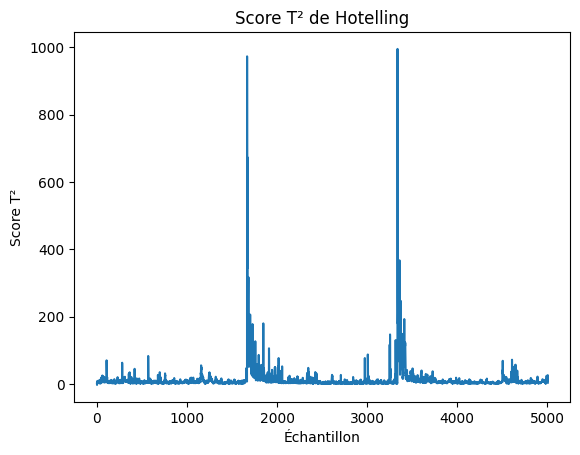

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Définir la taille de la fenêtre glissante
window_size = 1000

# Initialiser le DataFrame pour stocker les statistiques de la fenêtre glissante
window_data = pd.DataFrame(columns=X.columns)

# Initialiser la liste pour stocker les scores T²
t_squared_scores = []

# Parcourir les échantillons du DataFrame
for i, sample in X.iterrows():
    # Ajouter le nouvel échantillon à la fenêtre glissante
    window_data.loc[i % window_size] = sample
    
    # Calculer la moyenne et la matrice de covariance de la fenêtre glissante
    window_mean = window_data.mean()
    window_cov = window_data.cov()

    # Calculer le score T² de Hotelling pour le nouvel échantillon
    diff = sample - window_mean
    if(np.linalg.det(window_cov)==0):
        continue
    t_squared = diff.dot(np.linalg.inv(window_cov)).dot(diff)

    # Ajouter le score T² à la liste
    t_squared_scores.append(t_squared)

# Tracer les scores T²
plt.plot(t_squared_scores)
plt.xlabel('Échantillon')
plt.ylabel('Score T²')
plt.title('Score T² de Hotelling')
plt.show()

In [ ]:
X = pd.concat([X[y==1],X[y==2],X[y==0]], ignore_index=True)

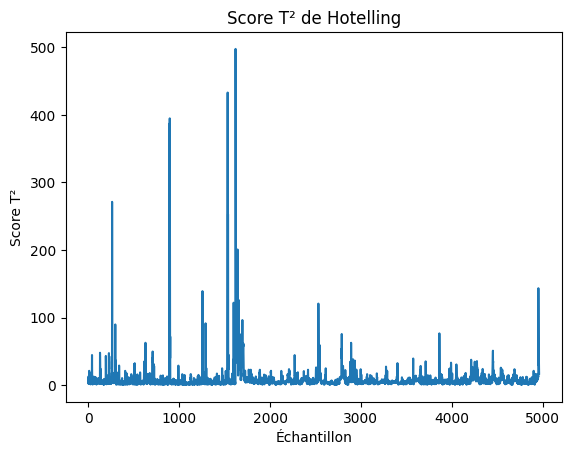

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Définir la taille de la fenêtre glissante
window_size = 500

# Initialiser le DataFrame pour stocker les statistiques de la fenêtre glissante
window_data = pd.DataFrame(columns=X.columns)

# Initialiser la liste pour stocker les scores T²
t_squared_scores = []

# Parcourir les échantillons du DataFrame
for i, sample in X.iterrows():
    # Ajouter le nouvel échantillon à la fenêtre glissante
    window_data.loc[i % window_size] = sample
    if(len(window_data)<50):
        continue
    # Calculer la moyenne et la matrice de covariance de la fenêtre glissante
    window_mean = window_data.mean()
    window_cov = window_data.cov()

    # Calculer le score T² de Hotelling pour le nouvel échantillon
    diff = sample - window_mean
    
    t_squared = diff.dot(np.linalg.inv(window_cov)).dot(diff)

    # Ajouter le score T² à la liste
    t_squared_scores.append(t_squared)

# Tracer les scores T²
plt.plot(t_squared_scores)
plt.xlabel('Échantillon')
plt.ylabel('Score T²')
plt.title('Score T² de Hotelling')
plt.show()